In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import imgaug

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
log_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"
log_file = root_dir / "current_training.log"

# Import the configuration associated with this dataset and network.
config = maskflow.load_config(root_dir / "config.yml")

Using TensorFlow backend.


# Load Training Dataset

In [4]:
# Split dataset
fnames = list((data_dir / "Image").glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.25, random_state=10)

# Build dataset
dataset_train = maskflow.MaskflowDataset()
dataset_train.set_dataset(train_fnames, config["CLASS_NAMES"])

dataset_val = maskflow.MaskflowDataset()
dataset_val.set_dataset(validation_fnames, config["CLASS_NAMES"])

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

train_fnames : 84 | validation_fnames : 28


{'id': 72, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_2.5_n-mts_160_id_0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_2.5_n-mts_160_id_0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_2.5_n-mts_160_id_0.csv')}


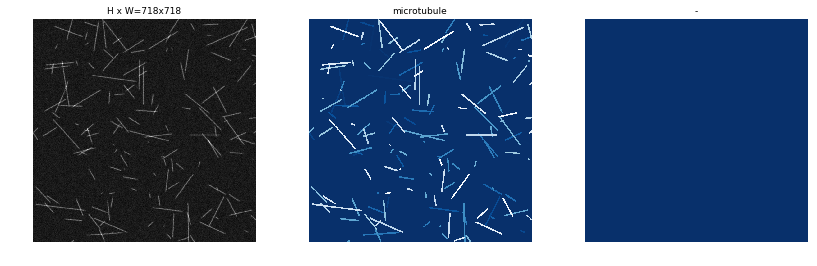

{'id': 22, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_1.9_n-mts_10_id_0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_1.9_n-mts_10_id_0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_1.9_n-mts_10_id_0.csv')}


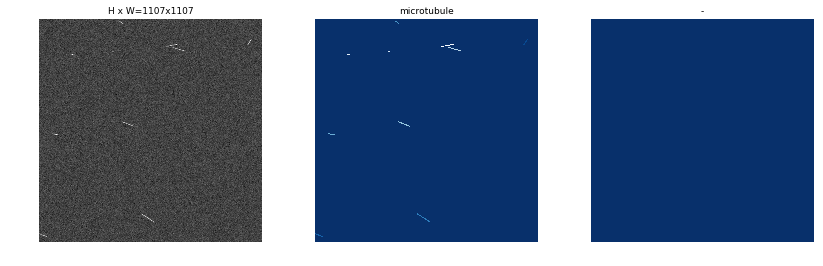

In [5]:
dataset_train.random_display(n=2, n_class=2)

# Training

In [4]:
maskflow_config = maskflow.MaskflowConfig(config)

maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.STEPS_PER_EPOCH = int(len(train_fnames) / maskflow_config.IMAGES_PER_GPU)

maskflow_config.update()
maskflow_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_SHAPES                [[320 320]
 [160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1, 0.1, 0.2, 0.2]
CLASS_NAMES                    ['microtubule']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1280
IMAGE_MIN_DIM                  100
IMAGE_MIN_SCALE                1.0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MAX_OBJECTS                    200
MEAN_PIXEL                     [123.7, 116.8, 103.9]
MINI_MA

In [5]:
# Callback to execute during training
callbacks = []
callbacks.append(maskflow.FileLogger(str(log_file)))
callbacks.append(maskflow.TelegramLogger())

Exception: Set TELEGRAM_TOKEN env variable.

In [6]:
model = maskflow.load_model(log_dir, maskflow_config, mode="training")

maskflow.load_weights(model, init_with="microtubule_detector20180624T1725")

# Copy config file to log directory
maskflow.save_config(config, Path(model.log_dir) / "config.yml")

Re-starting from epoch 104


In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=maskflow_config.LEARNING_RATE,
            epochs=1000, layers='heads', custom_callbacks=callbacks)

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=maskflow_config.LEARNING_RATE,
            epochs=1000, layers='all', custom_callbacks=callbacks)

# Load Trained Model

In [6]:
training_name = "microtubule_detector20180624T1725"

maskflow_config = maskflow.MaskflowConfig(config)
maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.update()

model = maskflow.load_model(log_dir, maskflow_config, mode="inference")
maskflow.load_weights(model, init_with=training_name)

# Load image with true predictions

In [ ]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 5

print(dataset_val.image_info[image_id])
image, mask, class_ids, bbox = dataset_val.load(image_id)
maskflow.display_instances(image, bbox, mask, class_ids, dataset_train.class_names, figsize=(8, 8))

{'id': 23, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/field_14_AUGMENTED_0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/field_14_AUGMENTED_0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/field_14_AUGMENTED_0.csv')}


# Predict

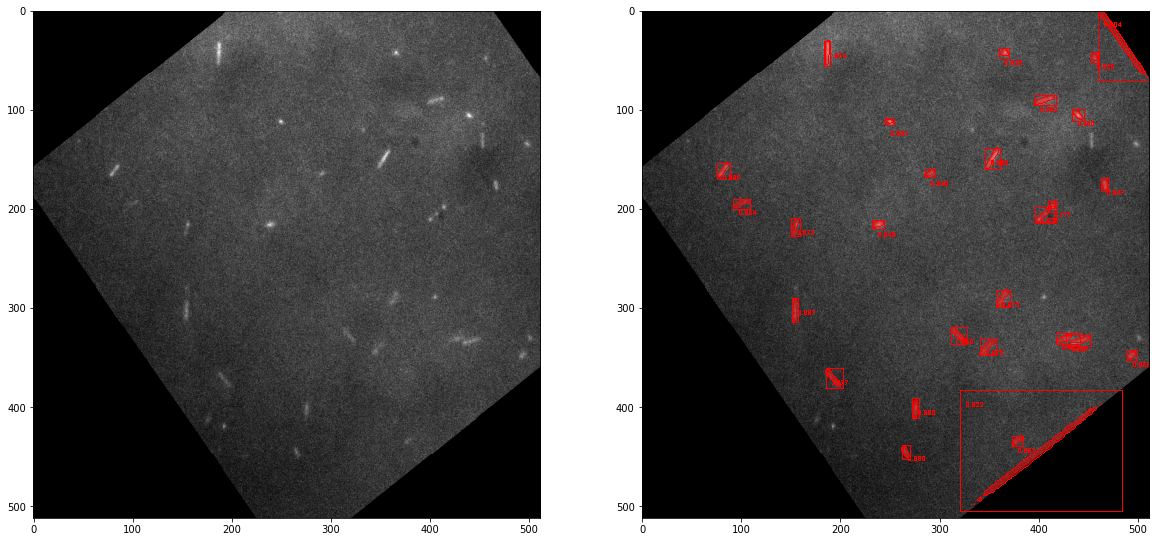

In [16]:
results = maskflow.predict(image, model, progress=True, verbose=0)

masked_images = maskflow.draw_results(image, results, model.config.CLASS_NAMES, colors=None, resize_ratio=1,
                                      draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([[image], masked_images], size=10)

# Export trained model to ZIP

In [5]:
model_name = "microtubule-v0.2"
model.log_dir = Path(model.model_dir) / training_name
maskflow.export_to_zip(model, model_name, saved_model_dir)

INFO:tensorflow:Froze 384 variables.
Converted 384 variables to const ops.
